In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing, model_selection
import scipy
import xgboost
import shap

In [2]:
synth_table = pd.read_csv('synth_table_spherefit_11_21_24.csv')

In [3]:
synth_table = synth_table.dropna()

Text(0, 0.5, 'PDI')

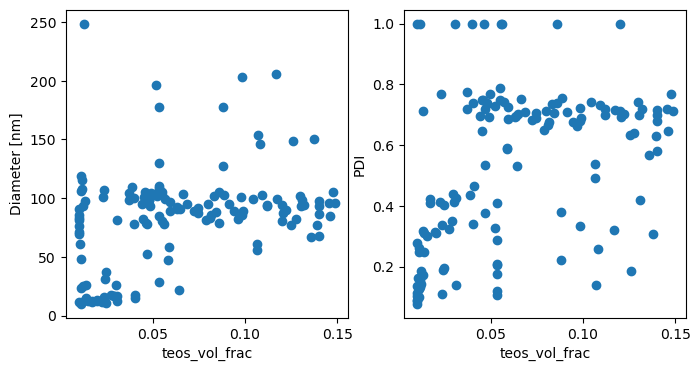

In [4]:
x = 'teos_vol_frac'
fix, ax = plt.subplots(1,2, figsize = (8, 4))

ax[0].scatter(synth_table[x], synth_table['diameter'])
ax[0].set_xlabel(x)
ax[0].set_ylabel('Diameter [nm]')

ax[1].scatter(synth_table[x], synth_table['pdi'])
ax[1].set_xlabel(x)
ax[1].set_ylabel('PDI')

Text(0, 0.5, 'PDI')

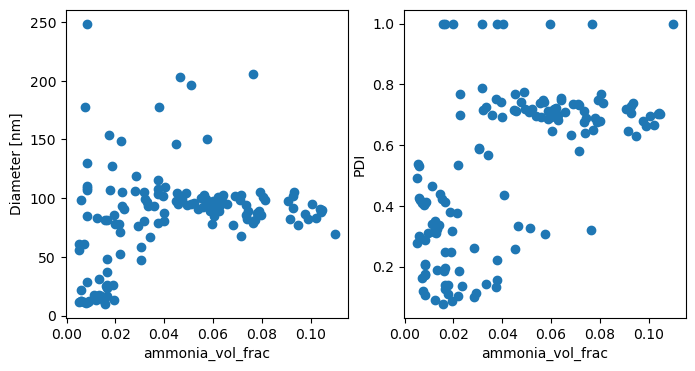

In [5]:
x = 'ammonia_vol_frac'
fix, ax = plt.subplots(1,2, figsize = (8, 4))

ax[0].scatter(synth_table[x], synth_table['diameter'])
ax[0].set_xlabel(x)
ax[0].set_ylabel('Diameter [nm]')

ax[1].scatter(synth_table[x], synth_table['pdi'])
ax[1].set_xlabel(x)
ax[1].set_ylabel('PDI')

Text(0, 0.5, 'PDI')

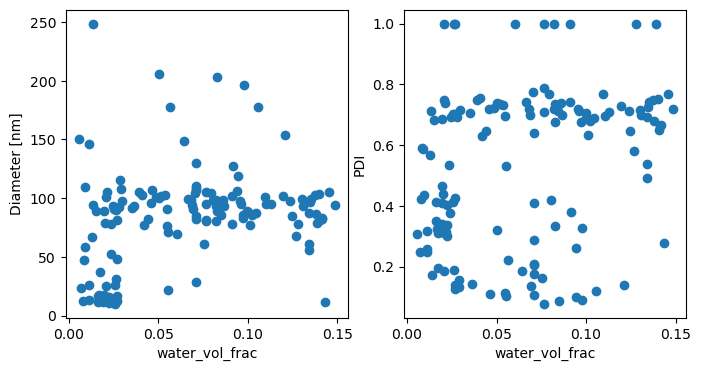

In [6]:
x = 'water_vol_frac'
fix, ax = plt.subplots(1,2, figsize = (8, 4))

ax[0].scatter(synth_table[x], synth_table['diameter'])
ax[0].set_xlabel(x)
ax[0].set_ylabel('Diameter [nm]')

ax[1].scatter(synth_table[x], synth_table['pdi'])
ax[1].set_xlabel(x)
ax[1].set_ylabel('PDI')

In [7]:
scipy.stats.pearsonr(synth_table['teos_vol_frac'].to_numpy(), synth_table['diameter'].to_numpy())

PearsonRResult(statistic=0.3629770577342858, pvalue=1.2120717039424343e-05)

In [8]:
scipy.stats.pearsonr(synth_table['teos_vol_frac'].to_numpy(), synth_table['pdi'].to_numpy())

PearsonRResult(statistic=0.41299119009286794, pvalue=4.803832994557506e-07)

In [9]:
scipy.stats.pearsonr(synth_table['ammonia_vol_frac'].to_numpy(), synth_table['diameter'].to_numpy())

PearsonRResult(statistic=0.3267125598362889, pvalue=9.192482792458141e-05)

In [10]:
scipy.stats.pearsonr(synth_table['ammonia_vol_frac'].to_numpy(), synth_table['pdi'].to_numpy())

PearsonRResult(statistic=0.5887649180629236, pvalue=3.082280737450855e-14)

In [11]:
scipy.stats.pearsonr(synth_table['water_vol_frac'].to_numpy(), synth_table['diameter'].to_numpy())

PearsonRResult(statistic=0.29772745378845233, pvalue=0.0003904331241818215)

In [12]:
scipy.stats.pearsonr(synth_table['water_vol_frac'].to_numpy(), synth_table['pdi'].to_numpy())

PearsonRResult(statistic=0.2844347066539996, pvalue=0.0007220319001792811)

## Linear model

In [13]:
## Fit a linear model
model_diameter = linear_model.LinearRegression()
model_pdi = linear_model.LinearRegression()

In [14]:
x = synth_table[['teos_vol_frac', 'ammonia_vol_frac', 'water_vol_frac']].to_numpy()
diameter = synth_table['diameter'].to_numpy()
pdi = synth_table['pdi'].to_numpy()

In [15]:
model_diameter.fit(x, diameter)

LinearRegression()

In [16]:
diameter_fit = model_diameter.predict(x)

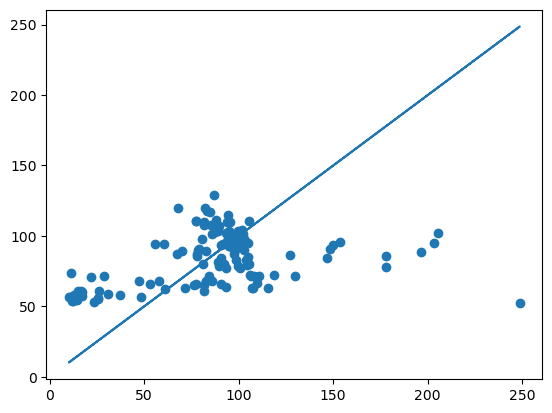

In [17]:
plt.scatter(diameter, diameter_fit)
plt.plot(diameter, diameter)

In [18]:
model_pdi.fit(x, pdi)
pdi_fit = model_pdi.predict(x)

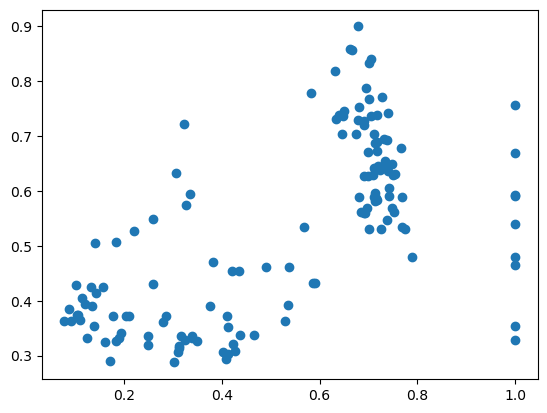

In [19]:
plt.scatter(pdi, pdi_fit)

## Do SHAP

In [20]:
scaler = preprocessing.MinMaxScaler()

In [34]:
x_scaled = scaler.fit_transform(x)
diam_scaled = scaler.fit_transform(diameter.reshape(-1,1))
pdi_scaled = scaler.fit_transform(pdi.reshape(-1,1))

In [54]:
## train test split
x_train, x_test, d_train, d_test = model_selection.train_test_split(x_scaled, diam_scaled, train_size = 0.8, random_state=10)
x_train, x_test, pdi_train, pdi_test = model_selection.train_test_split(x_scaled, pdi_scaled, train_size = 0.8, random_state=15)

In [55]:
regressor_d = xgboost.XGBRegressor()

In [56]:
regressor_d.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Using 110 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/28 [00:00<?, ?it/s]

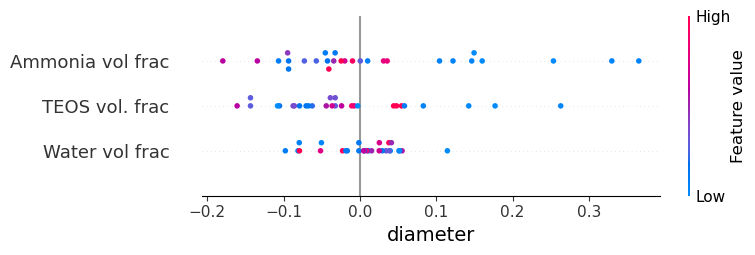

In [57]:
plt.rcParams.update({'font.size': 12})
x_test = pd.DataFrame(x_test, columns = ['TEOS vol. frac', 'Ammonia vol frac', 'Water vol frac'])
# shap_values = shap.TreeExplainer(model).shap_values(X_test)
# shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test)
fig, ax = plt.gcf(), plt.gca()
explainer = shap.KernelExplainer(regressor_d.predict, x_train)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, show=False)
ax.set_xlabel("diameter", fontsize=14)
#plt.savefig('../../Figures/230214/Shap_Plate_Thickness.png')
plt.show()



Text(0.5, 24.722222222222214, 'SHAP value')

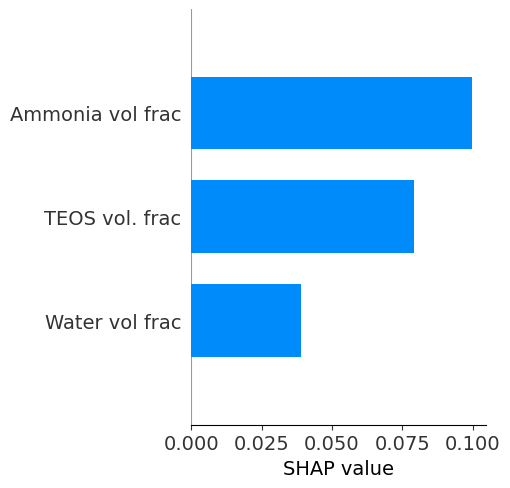

In [58]:
shap.summary_plot(shap_values, x_test, plot_type="bar", show=False, plot_size=[5,5])
fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value", fontsize=14)

In [59]:
regressor_pdi = xgboost.XGBRegressor()
regressor_pdi.fit(x_train, pdi_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Using 110 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/28 [00:00<?, ?it/s]

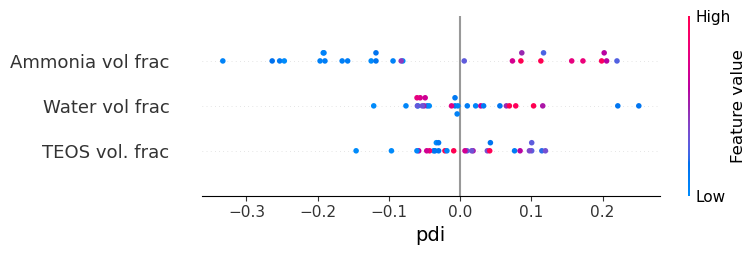

In [60]:
plt.rcParams.update({'font.size': 12})
x_test = pd.DataFrame(x_test, columns = ['TEOS vol. frac', 'Ammonia vol frac', 'Water vol frac'])
# shap_values = shap.TreeExplainer(model).shap_values(X_test)
# shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test)
fig, ax = plt.gcf(), plt.gca()
explainer = shap.KernelExplainer(regressor_pdi.predict, x_train)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, show=False)
ax.set_xlabel("pdi", fontsize=14)
#plt.savefig('../../Figures/230214/Shap_Plate_Thickness.png')
plt.show()


Text(0.5, 24.722222222222214, 'SHAP value')

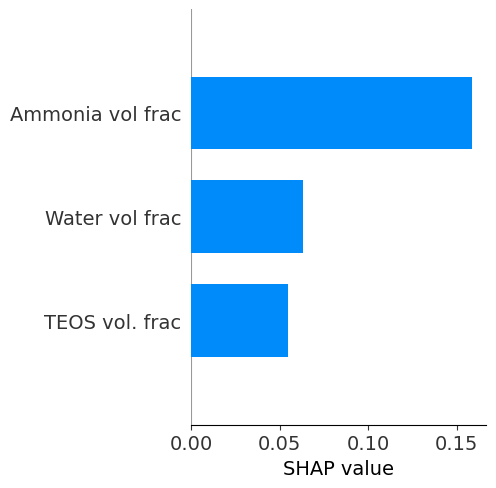

In [61]:
shap.summary_plot(shap_values, x_test, plot_type="bar", show=False, plot_size=[5,5])
fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value", fontsize=14)